In [ ]:
!pip install --upgrade pandas-datareader
!pip install -q yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

import yfinance as yf

# For time stamps
from datetime import datetime

#importing warnings to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Date Range for last 5 years
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day) #taking 5 year of data range from 2017 to 2022

df = yf.download('MSFT', start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-22,85.400002,85.629997,84.919998,85.510002,80.526047,14145800
2017-12-26,85.309998,85.529999,85.029999,85.400002,80.422455,9891200
2017-12-27,85.650002,85.980003,85.220001,85.709999,80.714378,14678000
2017-12-28,85.900002,85.930000,85.550003,85.720001,80.723785,10594300
2017-12-29,85.629997,86.050003,85.500000,85.540001,80.554291,18717400
...,...,...,...,...,...,...
2022-12-16,248.550003,249.839996,243.509995,244.690002,244.690002,86088100
2022-12-19,244.860001,245.210007,238.710007,240.449997,240.449997,29696400
2022-12-20,239.399994,242.910004,238.419998,241.800003,241.800003,25150800


# Prediction using Last 5 Years

In [ ]:
print(df.head())
print(df.shape)
print(df.columns)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-12-22  85.400002  85.629997  84.919998  85.510002  80.526047  14145800
2017-12-26  85.309998  85.529999  85.029999  85.400002  80.422455   9891200
2017-12-27  85.650002  85.980003  85.220001  85.709999  80.714378  14678000
2017-12-28  85.900002  85.930000  85.550003  85.720001  80.723785  10594300
2017-12-29  85.629997  86.050003  85.500000  85.540001  80.554291  18717400
(1259, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


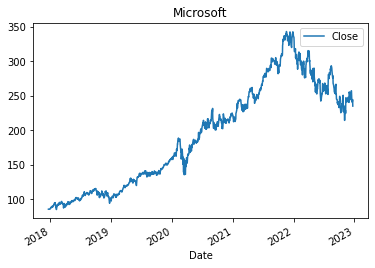

In [ ]:
df[['Close']].plot()
plt.title("Microsoft")
plt.show()

Text(0.5, 1.0, 'Microsoft Cumulative Returns')

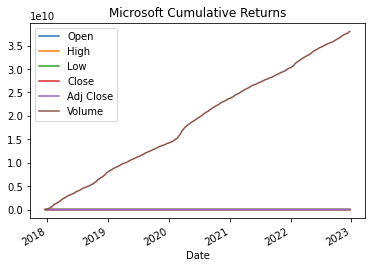

In [ ]:
# Comulative Return
dr = df.cumsum()
dr.plot()
plt.title('Microsoft Cumulative Returns')

Text(0.5, 1.0, 'Microsoft Correlation plot')

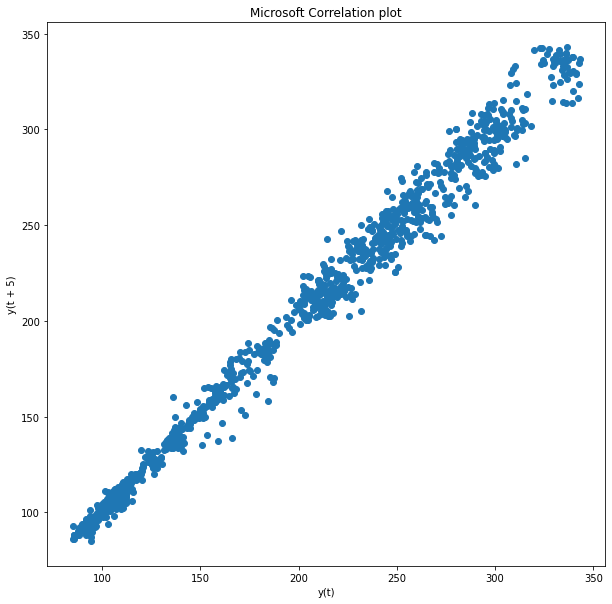

In [ ]:
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Microsoft Correlation plot')

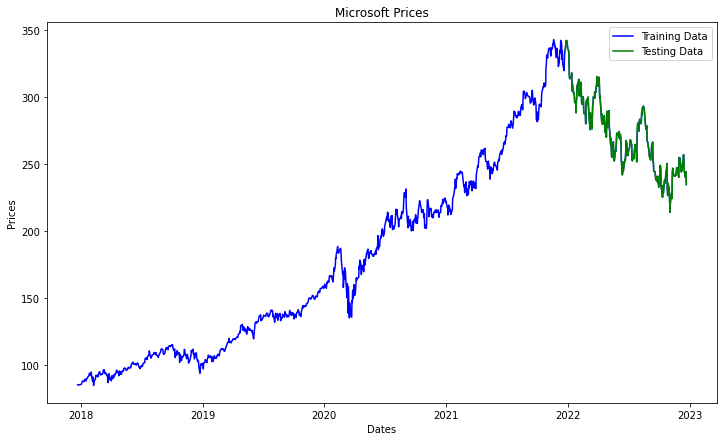

In [ ]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Microsoft Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

In [ ]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [ ]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error_rmse = np.sqrt(np.mean(((predictions - test_ar) ** 2)))
print('Testing Root Mean Squared Error: %.3f' % error_rmse)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Root Mean Squared Error: 38.949
Testing Mean Squared Error: 36.501
Symmetric mean absolute percentage error: 11.480


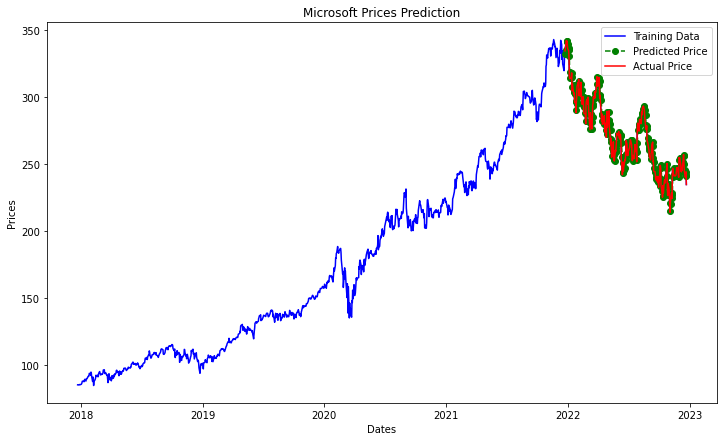

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

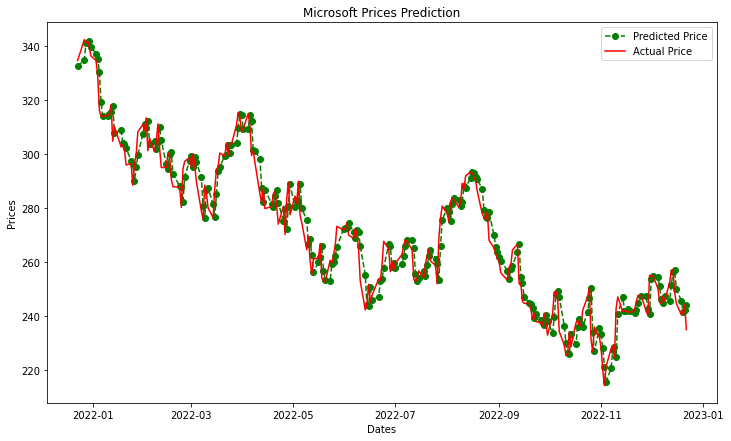

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Prediction Using Data for Recesssion Years

In [ ]:
# Date Range for The Great Recession - 1 Dec 2007 to 1 July 2009
rec_end = datetime(2009, 7, 1)
rec_start = datetime(2007, 12, 1)

df = yf.download('MSFT', rec_start, rec_end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-12-03,33.500000,33.639999,32.680000,32.919998,24.167334,61770600
2007-12-04,32.740002,33.240002,32.630001,32.770000,24.057213,54801500
2007-12-05,33.139999,34.520000,33.029999,34.150002,25.070303,84894700
2007-12-06,34.259998,34.610001,33.869999,34.549999,25.363949,49209700
2007-12-07,34.610001,34.700001,34.220001,34.529999,25.349268,40771000
...,...,...,...,...,...,...
2009-06-24,23.450001,23.750000,23.360001,23.469999,17.780331,54287700
2009-06-25,23.430000,23.920000,23.200001,23.790001,18.022758,57724300
2009-06-26,23.570000,23.690001,23.320000,23.350000,17.689426,65126400


In [ ]:
print(df.head())
print(df.shape)
print(df.columns)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2007-12-03  33.500000  33.639999  32.680000  32.919998  24.167334  61770600
2007-12-04  32.740002  33.240002  32.630001  32.770000  24.057213  54801500
2007-12-05  33.139999  34.520000  33.029999  34.150002  25.070303  84894700
2007-12-06  34.259998  34.610001  33.869999  34.549999  25.363949  49209700
2007-12-07  34.610001  34.700001  34.220001  34.529999  25.349268  40771000
(397, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


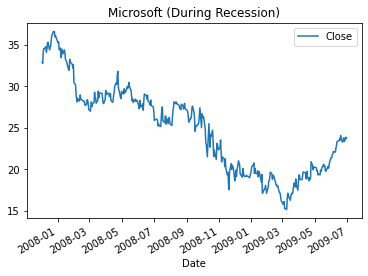

In [ ]:
df[['Close']].plot()
plt.title("Microsoft (During Recession)")
plt.show()

Text(0.5, 1.0, 'Microsoft Cumulative Returns (During Recession)')

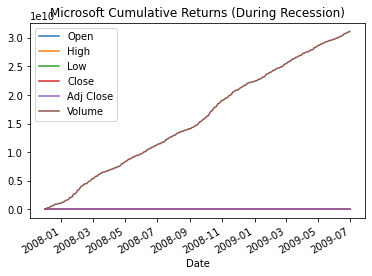

In [ ]:
# Comulative Return
dr = df.cumsum()
dr.plot()
plt.title('Microsoft Cumulative Returns (During Recession)')

Text(0.5, 1.0, 'Microsoft Correlation plot (During Recession)')

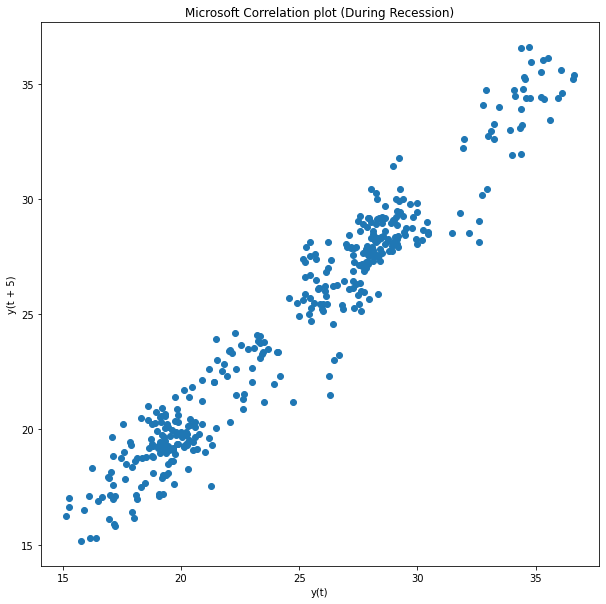

In [ ]:
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Microsoft Correlation plot (During Recession)')

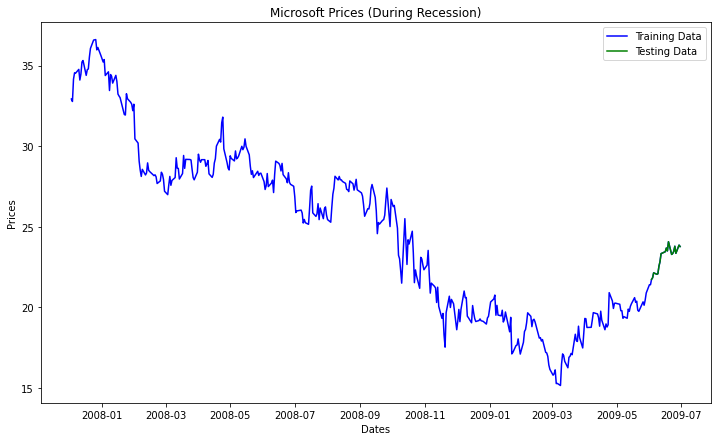

In [ ]:
train_data, test_data = df[0:int(len(df)*0.95)], df[int(len(df)*0.95):]
plt.figure(figsize=(12,7))
plt.title('Microsoft Prices (During Recession)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

In [ ]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error_rmse = np.sqrt(np.mean(((predictions - test_ar) ** 2)))
print('Testing Root Mean Squared Error: %.3f' % error_rmse)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Root Mean Squared Error: 1.112
Testing Mean Squared Error: 0.159
Symmetric mean absolute percentage error: 3.812


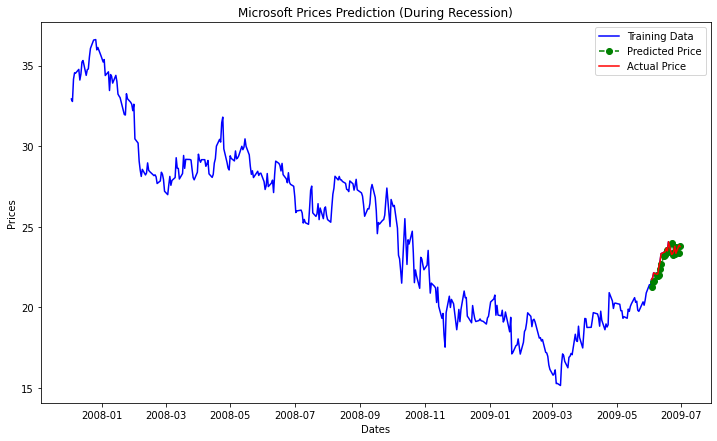

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction (During Recession)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

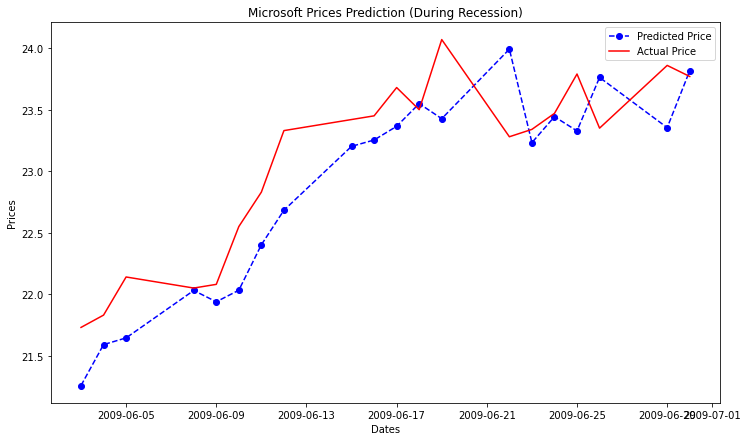

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='blue', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction (During Recession)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

# Prediction using Last 10 Years

In [ ]:
# Date Range for last 10 years
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day) #taking 10 year of data range from 2017 to 2022

df = yf.download('MSFT', start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-12-24,27.200001,27.250000,27.000000,27.059999,22.312922,20842400
2012-12-26,27.030001,27.200001,26.700001,26.860001,22.148010,31631100
2012-12-27,26.889999,27.090000,26.570000,26.959999,22.230469,39394000
2012-12-28,26.709999,26.900000,26.549999,26.549999,21.892391,28239900
2012-12-31,26.590000,26.770000,26.370001,26.709999,22.024323,42749500
...,...,...,...,...,...,...
2022-12-16,248.550003,249.839996,243.509995,244.690002,244.690002,86088100
2022-12-19,244.860001,245.210007,238.710007,240.449997,240.449997,29696400
2022-12-20,239.399994,242.910004,238.419998,241.800003,241.800003,25150800


In [ ]:
print(df.head())
print(df.shape)
print(df.columns)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-12-24  27.200001  27.250000  27.000000  27.059999  22.312922  20842400
2012-12-26  27.030001  27.200001  26.700001  26.860001  22.148010  31631100
2012-12-27  26.889999  27.090000  26.570000  26.959999  22.230469  39394000
2012-12-28  26.709999  26.900000  26.549999  26.549999  21.892391  28239900
2012-12-31  26.590000  26.770000  26.370001  26.709999  22.024323  42749500
(2518, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


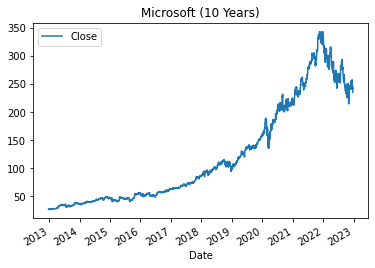

In [ ]:
df[['Close']].plot()
plt.title("Microsoft (10 Years)")
plt.show()

Text(0.5, 1.0, 'Microsoft Cumulative Returns (10 years)')

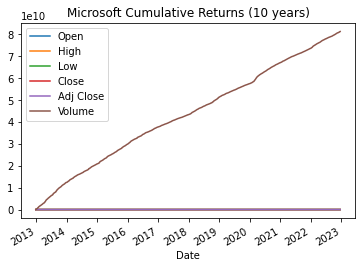

In [ ]:
# Comulative Return
dr = df.cumsum()
dr.plot()
plt.title('Microsoft Cumulative Returns (10 years)')

Text(0.5, 1.0, 'Microsoft Correlation plot (10 years)')

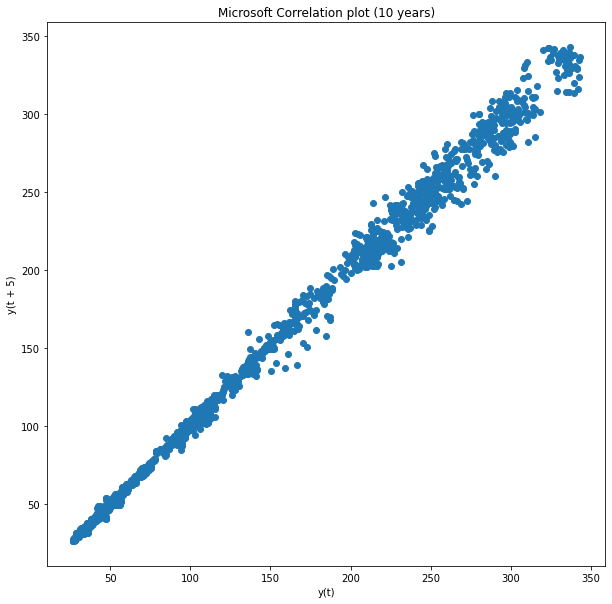

In [ ]:
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Microsoft Correlation plot (10 years)')

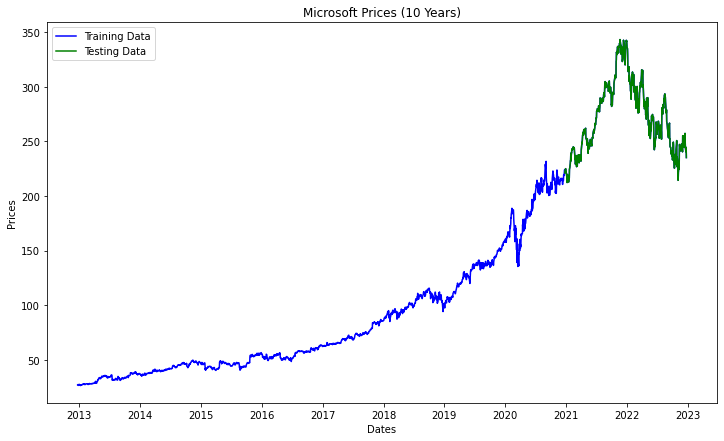

In [ ]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(12,7))
plt.title('Microsoft Prices (10 Years)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')
plt.legend()

In [ ]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error_rmse = np.sqrt(np.mean(((predictions - test_ar) ** 2)))
print('Testing Root Mean Squared Error: %.3f' % error_rmse)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Root Mean Squared Error: 45.592
Testing Mean Squared Error: 24.954
Symmetric mean absolute percentage error: 13.413


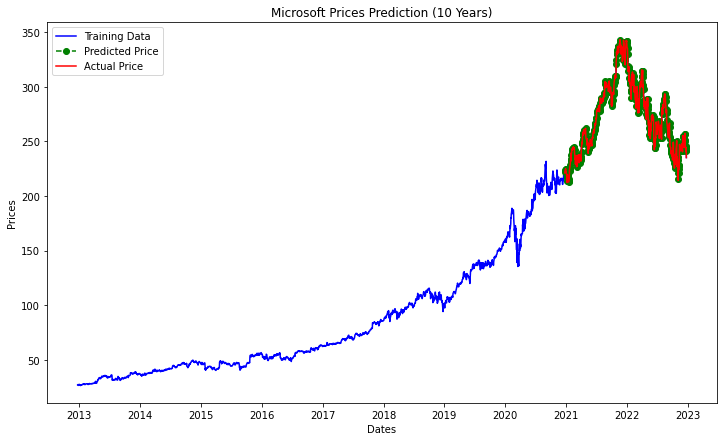

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction (10 Years)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

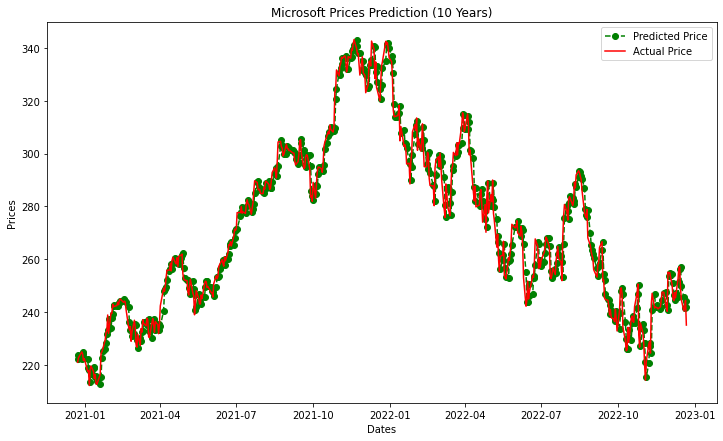

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction (10 Years)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()